# Poisson-BVP-3

This notebook implements the BCGP experiments for Poisson-BVP-3 from Section 5.2.3 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ['JAX_PLATFORM_NAME'] = 'cpu'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random, devices, vmap

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append('../../')

import jax_pigp
from jax_pigp.utility_fns import softplus, generate_params, PARAM_OPTIONS_DICT as param_gen_options
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True) 
config.update("jax_debug_nans", False) 

Check what devices are available

In [3]:
devices()

[CudaDevice(id=0)]

#### Specify settings of the experiments

Ensure that this cell is tagged as "parameters" when using papermill

In [4]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 1572

# true value of the pde parameter theta 
THETA_TRUE: Array  = jnp.array([1.])

# bounds from which to randomly sample initial value of theta
THETA_MIN: Array = jnp.array([.5])
THETA_MAX: Array = jnp.array([2.5])
THETA_BOUNDS = [THETA_MIN, THETA_MAX]

# Set to true to consider inverse problem of identifying theta
RUN_INVERSE: bool = True

# specify how GP handles boundary condnitions 
GP_TYPE = 'bcgp'
assert GP_TYPE in ['bcgp', 'ucgp'] 

# number of u/f/g space observations to use for inference
N_DATA: int = 25
Nu: int = N_DATA
Nf: int = N_DATA

# subdirectory in data/ where PDE data is stored
data_save_dir: str = f'poissonBVP3'
data_save_dir_full = os.path.join('data', data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatial domain 
INPUT_DIM: int = 2

# initial value for std of noise levels for u / f points
NOISE_INIT = jnp.array([0.1, 0.1])

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = True

# options for model training
N_TRAIN_STEPS: int = 12500
N_RESTARTS: int    = 3
LR_INIT: float     = 0.002
VERBOSE: bool      = False

### Specify boundary-constrained mean and kernel functions

The BCGP mean and kernel functions are discussed in Appendix B.2.8 of the manuscript, and they are designed to ensure that the BCGP exactly satisfies the Dirichlet condition on $\partial \Omega_1$ and Neumann condition on $\partial \Omega_2$.

The mean function is simply set to zero 

In [5]:
mean_fn = lambda p, x: x[0]*0.

The kernel $\tilde{k}(x, x')$ takes the form

\begin{equation*}
	\tilde{k}([x,y],[x',y']) = \mathcal{B}^{m_1}_{x,y} \mathcal{B}^{m_1}_{x',y'} k_1([x,y],[x',y']) + \mathcal{B}^{m_2}_{x, y} \mathcal{B}^{m_2}_{x', y'} k_2([x,y],[x',y']) ,
\end{equation*}

in which $k_1$ and $k_2$ are squared-exponential kernels:

In [6]:
BASE_KERNEL = jax_pigp.kernels.squared_exponential

$\mathcal{B}^{m_1}_{x,y}$ and $\mathcal{B}^{m_2}_{x,y}$ are given by
\begin{align*}  
    \mathcal{B}^{m_1}_{x,y}[\cdot](x,y) &= \left(\phi_1(x,y) - \phi(x,y) \nabla \phi_2(x,y) \cdot \nabla \phi_1(x,y) \right)[\cdot](x,y) \\
& - \phi(x,y) \phi_1(x,y) \nabla \phi_2(x,y) \cdot \nabla [\cdot](x,y),  \\ %.
    \mathcal{B}^{m_2}_{x,y}[\cdot](x,y) &= \phi(x,y) \phi_2(x,y) [\cdot](x,y). \notag
\end{align*}


The ADFs $\phi_1$, $\phi_2$, $\phi$ have the form

In [7]:
def dist(x1,y1,x2,y2):
    return jnp.sqrt((x2-x1)**2+(y2-y1)**2)

def linseg_dist(loc: Array, segment: Array):
    # returns distance from loc to line segment
    # with end points contained in segment
    # based on code from https://arxiv.org/abs/2104.08426

    x, y = loc
    x1,y1,x2,y2 = segment
    
    L = dist(x1,y1,x2,y2)
    
    xc = (x1+x2)/2.
    yc = (y1+y2)/2.
    
    h = (1/L)*((x-x1)*(y2-y1) - (y-y1)*(x2-x1))
    t = (1/L)*((L/2.)**2-dist(x,y,xc,yc)**2)
    
    tmp_val = jnp.sqrt(t**2+h**4)
    
    return jnp.sqrt(h**2 + (1/4.)*(tmp_val-t)**2)

# vmap to evaluate ADF for each boundary line segment at the same time
linseg_dist_vmap = vmap(linseg_dist, in_axes=[None,0])

Then, the ADF $\phi$ is found using the R-equivalence join from Eq.(25) of the manuscript:

In [8]:
# coords of the end points of the exterior line segments
exterior_surfaces = jnp.load(f'{data_save_dir_full}/geometryData/exterior_line_segments.npy')

# R-equivalence join
def phi1(loc: Array):
    phi_vals = linseg_dist_vmap(loc, exterior_surfaces)
    phi_inv_sum = jnp.sum(1./phi_vals)
    return 1./phi_inv_sum

grad_phi1 = jacrev(phi1)

In [9]:
def phi2(loc:Array):
    _, y = loc
    return y

grad_phi2 = jacrev(phi2)

Then, the ADF $\phi$ is found using the R-equivalence join from Eq.(25) of the manuscript:

In [10]:
def phi(loc):

    phi_vals = jnp.array([phi1(loc), phi2(loc)])

    phi_sum = jnp.sum(phi_vals)
    phi_total = jnp.prod(phi_vals) / phi_sum
    return_val = jnp.where(phi_sum > 0., phi_total, 0.)

    return return_val

$\mathcal{B}^{m_1}_{x,y}$ and $\mathcal{B}^{m_2}_{x,y}$ can then be implemented as follows:

In [11]:
def apply_B1(fn: Callable, argnum: int = 1):

    # the Jacobian function
    Jfn, _ = jac_hess(fn, argnum)

    def B1(params: dict, loc1: Array, *loc2: Array):
        
        loc = loc1 if argnum == 1 else loc2[0]

        fn_val = fn(params, loc1, *loc2)
        J_val = Jfn(params, loc1, *loc2)
    
        phi1_val = phi1(loc)
        phi2_val = phi2(loc)
        gradphi1_val = grad_phi1(loc)
        gradphi2_val = grad_phi2(loc)
    
        phi_val = phi(loc)
        
        # temporary values in line with the form of B1 given above
        tmp1 = phi1_val*fn_val 
        tmp2 = (gradphi2_val*gradphi1_val).sum()*fn_val
        tmp3 = (gradphi2_val*J_val).sum()*phi1_val
    
        return (tmp1 - phi_val*(tmp2 + tmp3)).squeeze()
        
    return B1

def B2(loc):
    return phi(loc)*phi2(loc)

And finally $\tilde{k}$ can be defined

In [12]:
def get_kernel_fn(base_kernel):

    Bm1_k1 = apply_B1(apply_B1(base_kernel, 1), 2) 
    k2 = base_kernel

    def bcgp_kernel(params: dict, loc1: Array, loc2: Array):

        k1_params = params['kernel_params_1']
        
        # comment / uncomment below to use same or differnt parameters for k2
        # k2_params = params['kernel_params_2']
        k2_params = k1_params

        Bm1_k1_val = Bm1_k1(k1_params, loc1, loc2)
        Bm2_k2_val = B2(loc1)*B2(loc2)*k2(k2_params, loc1, loc2)
        
        return Bm1_k1_val + Bm2_k2_val

    return bcgp_kernel


Choose whether to use boundary constrained kernel of normal kernel based on value of ``GP_TYPE``

In [13]:
if GP_TYPE == "bcgp":
    print(f'using boundary constrained kernel')

    kernel_fn = get_kernel_fn(BASE_KERNEL)

else:
    def kernel_fn(params: dict, loc1: Array, loc2: Array):
    
        k_params = params['kernel_params_1']
    
        cov_val = BASE_KERNEL(k_params, loc1, loc2)
    
        return cov_val


using boundary constrained kernel


### Specify Poisson differential operator

Recall that Poisson's equation over two spatial dimensions takes the form

$$\mathcal{L}^{\theta}_{x,y}[u] =   -\theta \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) = f = 4.$$

##### Implementation: 

* We define a dummy linear operator for $u$-space data which is just the identity transformation
* $f$ is returned by calling the ``apply_PDE`` function defined below


In [14]:
def apply_Identity(fn: Callable,argnum: int = 1):
    return fn

def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the Poisson PDE to input fn at specified argnum
    """

    # the Hessian function
    _, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):

        theta = THETA_TRANSFORM(params['theta'])[0] if RUN_INVERSE else THETA_TRUE[0]
        
        # Laplacian (i.e. sum of second spatial derivatives) is the trace of the Hessian matrix 
        uxx_val, uyy_val = jnp.diag(Hfn(params, loc1, *loc2))
        
        return theta*(uxx_val + uyy_val)
        
    return PDE 

# the first operator corresponds to the observations yu and the second to pde observations yf
linear_operators = [apply_Identity, apply_PDE]

### Store settings

Store optimisation options in a dictionary

In [15]:
opt_options = {}
opt_options['n_steps']         = N_TRAIN_STEPS 
opt_options['n_restarts']      = N_RESTARTS
opt_options['lr']              = LR_INIT
opt_options['verbose']         = VERBOSE
opt_options['theta_transform'] = THETA_TRANSFORM
opt_options['noise_transform'] = NOISE_TRANSFORM

Specify parameter initialisation function

In [16]:
param_gen_options['n_sub_kernels'] = 2 if GP_TYPE == 'bcgp' else 1
param_gen_options['input_dim']       = [INPUT_DIM]*param_gen_options['n_sub_kernels']
param_gen_options['theta_bounds']    = THETA_BOUNDS
param_gen_options['theta_transform'] = THETA_TRANSFORM
param_gen_options['noise_std_init']  = NOISE_INIT
param_gen_options['noise_transform'] = NOISE_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [17]:
results_save_dir = os.path.join('results', data_save_dir, f'{GP_TYPE}_Nu_{Nu}_Nf_{Nf}')
if not os.path.isdir(results_save_dir): os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [18]:
train_data, test_data = load_data(data_save_dir_full, Nu, Nf)

Check shapes of train and test data

In [19]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((50, 1), (1388, 1), [(25, 2), (25, 2)])

### Plot ADFs

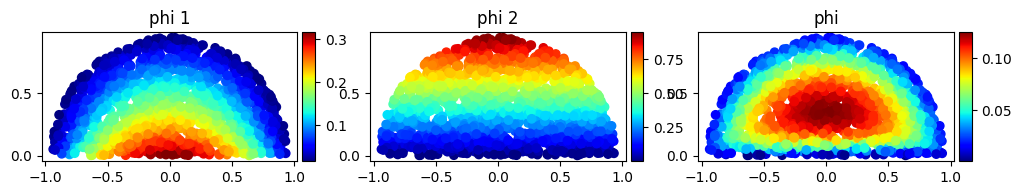

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=THREE_COLUMN_FIGSIZE)

phi1_vals = vmap(phi1)(test_data.Xs)
make_scatter_heatmap(axes[0], test_data.Xs, phi1_vals, "phi 1")

phi2_vals = vmap(phi2)(test_data.Xs)
make_scatter_heatmap(axes[1], test_data.Xs, phi2_vals, "phi 2")

phi_vals = vmap(phi)(test_data.Xs)
make_scatter_heatmap(axes[2], test_data.Xs, phi_vals, "phi")

plt.savefig(os.path.join(results_save_dir, 'ADF.pdf'))

### Initialise PIGP model

In [21]:
poisson_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(kernel_fn, linear_operators)
poisson_mean_fns   = jax_pigp.interdomain_moments.InterdomainMeanFns(mean_fn,     linear_operators)

gp_model = jax_pigp.models.GPR(poisson_kernel_fns, poisson_mean_fns)

### Initialise learner for model training

In [22]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)    

gp_learner = jax_pigp.optimisers.AdamLearner(obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL))

Initial parameter values  

In [23]:
print_param_values(gp_learner.params, opt_options)

kernel_params_1
amp: [13.22625438]
ls: [4.25870878 3.8917167 ]
alpha: [14.17676047]

kernel_params_2
amp: [20.76168518]
ls: [2.13855857 2.47213226]
alpha: [23.56247812]

noise_std: [0.1 0.1]
theta: [0.57000326]


Objective function value for initial parameters

In [24]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-406.65494431, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [25]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(406.65494431, dtype=float64),
 {'kernel_params_1': {'alpha': Array([0.], dtype=float64),
   'amp': Array([-4.69802536], dtype=float64),
   'ls': Array([23.00526746, 15.83698961], dtype=float64)},
  'kernel_params_2': {'alpha': Array([0.], dtype=float64),
   'amp': Array([0.], dtype=float64),
   'ls': Array([0., 0.], dtype=float64)},
  'noise_std': Array([-410.22895227, -295.80043411], dtype=float64),
  'theta': Array([-931.01458975], dtype=float64)})

## Training 

JIT compile the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [26]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [27]:
print(f'gp_type={GP_TYPE}, Nu/Nf={Nu}/{Nf}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n')
gp_learner.train_with_restarts(opt_options['n_steps'], 
                               opt_options['n_restarts'], 
                               print_progress = opt_options['verbose'])

gp_type=bcgp, Nu/Nf=25/25, n_steps=12500, n_restarts=3

Restart 0: beginning training for 12500 steps
Final training results: 
(12499): -57.9516, noise_std_vals = [1.02e-02,9.22e-02], theta = [1.004327]


Restart 1: beginning training for 12500 steps
Final training results: 
(12499): -65.8874, noise_std_vals = [7.37e-03,8.38e-03], theta = [1.01569282]


Restart 2: beginning training for 12500 steps
Final training results: 
(12499): -57.4821, noise_std_vals = [1.03e-02,9.20e-02], theta = [1.00471504]




Uncomment below to continue training from existing parameter values:

In [28]:
# gp_learner.train(opt_options["n_steps"])
# gp_learner.params_best = gp_learner.params.copy()

### Plot training results

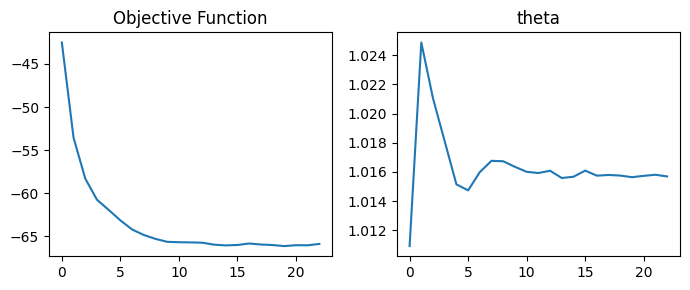

In [29]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=TWO_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list)*0.15)

plot_lc(axes[0], gp_learner.obj_list[begin_at:], 'Objective Function')
plot_lc(axes[1], theta_arr[begin_at:,0], 'theta')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'learningCurves.pdf'))

### Final trained parameter values

In [30]:
# extract final trained parameter values
trained_params = gp_learner.params_best.copy()

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'wb') as fp:
    pickle.dump(trained_params, fp)

kernel_params_1
alpha: [23.35562953]
amp: [31.75043915]
ls: [1.19526429 0.87610875]

kernel_params_2
alpha: [16.89883419]
amp: [15.88919686]
ls: [1.01032657 1.24197632]

noise_std: [0.00736736 0.00838148]
theta: [1.01569282]


Can load pre-trained parameters by uncommenting the below

In [31]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [32]:
# posterior mean and covariance over test points
print(f'Posterior results for {GP_TYPE}, Nu/Nf={train_data.Xtrain[0].shape[0]}/{train_data.Xtrain[1].shape[0]}, Ns={test_data.Xs.shape[0]}')
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)
s = jnp.diag(Sigma)**.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, 'u_pred.npy'), mu)
    jnp.save(os.path.join(results_save_dir, 's_pred.npy'), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f'mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}')
savetxt(os.path.join(results_save_dir, 'mean_loss.txt'), abs_losses.mean().reshape(-1,1))

if RUN_INVERSE:
    theta_pred = opt_options['theta_transform'](trained_params['theta'])
    theta_loss = jnp.linalg.norm(theta_pred - THETA_TRUE)
    print(f'theta_true : {THETA_TRUE}')
    print(f'theta_pred : {theta_pred}')
    print(f'theta_loss : {theta_loss:.3e}')
    savetxt(os.path.join(results_save_dir, 'theta_loss.txt'), jnp.array([theta_loss]))

Posterior results for bcgp, Nu/Nf=25/25, Ns=1388
mean/max loss: 5.605686e-03/4.573e-02
theta_true : [1.]
theta_pred : [1.01569282]
theta_loss : 1.569e-02


### Plots of posterior prediction

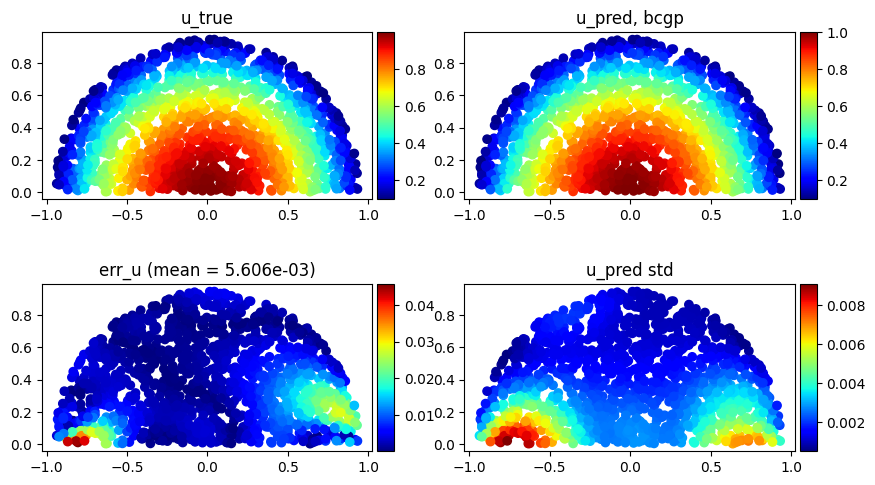

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=TWO_BY_TWO_FIGSIZE)

make_scatter_heatmap(axes[0,0], test_data.Xs, test_data.us, title='u_true')
make_scatter_heatmap(axes[0,1], test_data.Xs, mu, title=f'u_pred, {GP_TYPE}')
make_scatter_heatmap(axes[1,0], test_data.Xs, abs_losses, title=f'err_u (mean = {abs_losses.mean():.3e})')
make_scatter_heatmap(axes[1,1], test_data.Xs, s, title=f'u_pred std')

plt.savefig(os.path.join(results_save_dir, 'posteriorPrediction.pdf'))